In [1]:
from models import TimeSeriesProcessor, ForALS, DfFunctions

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

dfun = DfFunctions.DfFunctions()
proc = TimeSeriesProcessor.TimeSeriesDataProcessor()
fals = ForALS.ForALS()
cl = ForALS.Clustering()

# DONE


## Data Cleaning

**raw_data** - сырые данные 

**df** - очищенные данные

**mapping_matrix_id** - таблица соответствия user_id и numeric_user_id

**mapping_matrix_trackable** - таблица соответствия trackable_name и numeric_trackable_name

In [2]:
DF_NAME="df_condition"
PATH = '/Users/kaledinaoa/data/data_chronic_illness/'

min_num_of_records = 20
min_trackable_name_count = 50
min_num_of_dates = 6

NUM_TOP_K = 1000

**def clean_df(df)**

1. Удаляем, где у юзеров нет age/sex/country (данных достаточно)
2. Подсчитываем количество встречаемости trackable_name
3. Выбираем записи, где количество встречаемости trackable_name > **min_trackable_name_count**
4. Удаляем ненужные колонки
5. Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= **min_num_of_records**
6. Оставляем в df_clean только отфильтрованные user_id
7. Фильтруем, что у пользователя количество дат записей >= **min_num_of_dates**
8. Созлаем матрицы соответствия для 'user_id' и 'trackable_name'
9. Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
10. Меняем порядок колонок


In [3]:

def clean_df(df):
    
    # proc.list_methods()
    df.columns = [col.lower() for col in df.columns]
    # Удаляем, где у юзеров нет age/sex/country (данных достаточно)
    df_new = df.dropna(subset=['age', 'sex','country'])
    # Подсчитываем количество встречаемости trackable_name
    df_count_trackable_name = proc.calculate_counttable_by_columnname(df,"trackable_name").sort_values(by='count', ascending=False)
    # Выбираем записи, где количество встречаемости trackable_name > min_trackable_name_count
    df_clean = proc.delete_rows_with_higher_count(df=df_new, df_count=df_count_trackable_name, min_count=min_trackable_name_count, col='trackable_name')
    # Удаляем ненужные колонки
    df_clean = proc.drop_columns_by_columnsnames(df_clean, ['count', 'trackable_type'])
    # Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= min_num_of_records
    filtered_users_with_counts = proc.filter_by_min_records(df_clean, min_num_of_records)
    # Оставляем в df_clean только отфильтрованные user_id
    df_clean = df_clean[df_clean['user_id'].isin(filtered_users_with_counts["user_id"])]
    # Фильтруем, что у пользователя количество дат записей >= min_num_of_dates
    df_clean = proc.filter_by_min_number_of_dates(df_clean, min_num_of_dates)

    # Create mapping matrices for 'user_id' and 'trackable_name'
    mapping_matrix_id, df_cleaned = proc.create_mapping_matrix(df_clean, 'user_id')
    mapping_matrix_trackable, df_cleaned = proc.create_mapping_matrix(df_clean, 'trackable_name')
   
    # Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
    df_c = proc.drop_columns_by_columnsnames(df_cleaned,['user_id'])

    # Меняем порядок колонок
    new_order = ['numeric_user_id', 'age', 'sex','country','checkin_date','numeric_trackable_name','trackable_name','trackable_value']
    df_c = df_c.reindex(columns=new_order)

    return df_c, mapping_matrix_id, mapping_matrix_trackable

raw_data = proc.load_csv(DF_NAME, PATH)

df_cleaned, mapping_matrix_id, mapping_matrix_trackable = clean_df(raw_data.copy())

print("Percent of saved rows = {percent:.2f}% or {num:d} rows".format(percent=df_cleaned.shape[0]*100/raw_data.shape[0], num=df_cleaned.shape[0]))

Percent of saved rows = 72.96% or 810981 rows


In [4]:
mapping_matrix_trackable

,trackable_name,numeric_trackable_name
0,ulcerative colitis,0
1,headache,1
2,diziness,2
3,obsessivecompulsive disorder,3
4,ovarian cysts,4
...,...,...
1494,bad balance,1494
1495,chronic allergic rhinitis,1495
1496,self control around food,1496
1497,attention span,1497


## Split to train_df, val_df, test_df

my_test: 70% : 15% : 15% (по датам)

**train** = percent*100% ; **val** = (1-percent)*100/2% ; **test** = (1-percent)*100/2%

In [5]:
df = df_cleaned.copy()

# train_df, val_df, test_df = fals.split_to_train_val_test_percent(df, percent_train = 0.7)
train_df, test_df = fals.split_to_train_test_last_day(df)

### info about df's

In [6]:
def print_df_info(df, id='numeric_user_id', tr='numeric_trackable_name'):
    users, items, interactions = df[id].nunique(), df[tr].nunique(), df.shape[0]
    # info_str = '# users: ' + str(users) + ' # items: ' + str(items) + ' # interactions: ' + str(interactions)
    str = """users: {us:5}, items: {it:5}, interactions: {inter:7}""".format(us=users, it=items, inter=interactions)
    return str

print("raw_data:   ", print_df_info(raw_data, id='user_id', tr='trackable_name'))
print("df_cleaned: ", print_df_info(df_cleaned))
print("train_df:   ", print_df_info(train_df))
# print("val_df:     ", print_df_info(val_df))
print("test_df:    ", print_df_info(test_df))

raw_data:    users: 38308, items:  8981, interactions: 1111517
df_cleaned:  users:  4892, items:  1499, interactions:  810981
train_df:    users:  4892, items:  1499, interactions:  788424
test_df:     users:  4892, items:  1441, interactions:   22557


### test user

In [7]:
def user_print(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    return "Dates: {dates}, Rows: {rows}".format(dates=df_user['checkin_date'].drop_duplicates().shape[0],rows=df_user.shape[0])

def user_df(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    df_sorted = df_user.sort_values(by='checkin_date')
    return df_sorted

def info_split_with_val(train, val, test, test_user):
    print("TRAIN :",user_print(train, test_user))
    print("VALID :",user_print(val, test_user))
    print("TEST  :",user_print(test, test_user))
    pass

def info_split(train, test, test_user):
    print("TRAIN :",user_print(train, test_user))
    print("TEST  :",user_print(test, test_user))
    pass

In [8]:
test_user_id = 3
info_split(train_df, test_df, test_user_id)

TRAIN : Dates: 204, Rows: 811
TEST  : Dates: 1, Rows: 3


In [9]:
# user_df(train_df,test_user_id)
# user_df(test_df,test_user_id)
# user_df(val_df,test_user_id)

## Creation of user_item_matrix

**user_item_matrix** = user_ids x top_k

In [10]:
# выбираем топ по количеству встречаемости
def top_table_by_count(df, top_k):
    popularity = proc.calculate_counttable_by_columnname(df,'numeric_trackable_name')
    top = popularity.sort_values('count', ascending=False).head(top_k)
    return top

top_k = top_table_by_count(train_df, NUM_TOP_K)
top_k_list = top_k.numeric_trackable_name.tolist()
# top_k.sort_values(by='numeric_trackable_name', ascending=False).head(10)
# top_k

In [181]:
# замена редко встречающихся диагнозов на 999999
train_df.loc[~train_df['numeric_trackable_name'].isin(top_k_list), 'numeric_trackable_name'] = 999999

# map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index().sort_values(by="numeric_trackable_name")
# map_new = map_new.drop(columns=['index'])
# map_new.head(20)

map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index()
map_new = map_new.drop(columns=['index'])
map_new = map_new.sort_values(by="numeric_trackable_name").reset_index()
map_new = map_new.drop(columns=['index']).reset_index()
map_new.head(5)
# map_new.sort_value(by="numeric_trackable_name").head(40)

<ipython-input-181-b981cb7af20a>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index()


,index,numeric_trackable_name,trackable_name
0,0,0,ulcerative colitis
1,1,1,headache
2,2,3,obsessivecompulsive disorder
3,3,4,ovarian cysts
4,4,5,sinus headaches


In [182]:
mapping_matrix_trackable.head()

,trackable_name,numeric_trackable_name
0,ulcerative colitis,0
1,headache,1
2,diziness,2
3,obsessivecompulsive disorder,3
4,ovarian cysts,4


In [176]:
train_df.sort_values(by="numeric_user_id").head()

,numeric_user_id,age,sex,country,checkin_date,numeric_trackable_name,trackable_name,trackable_value
13,0,41.0,other,GB,2015-05-26,0,ulcerative colitis,3
494678,0,41.0,other,GB,2015-10-22,95,urinary frequency,2
592324,0,41.0,other,GB,2015-05-30,180,angioedema,2
591683,0,41.0,other,GB,2015-05-30,179,urinary incontinence,2
568644,0,41.0,other,GB,2015-05-30,160,chronic pain,2


In [14]:
user_item_matrix = pd.pivot_table(train_df, 
                                  index='numeric_user_id', columns='numeric_trackable_name', 
                                  values='trackable_value',
                                  aggfunc='sum', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(10)

numeric_trackable_name,0,1,3,4,5,6,7,8,9,10,...,1483,1484,1488,1489,1490,1491,1492,1493,1494,999999
numeric_user_id,,,,,,,,,,,,,,,,,,,,,
0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model ALS

In [15]:
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
 

In [16]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = fals.some_ids_preparation_to_als(user_item_matrix)

In [17]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=30, 
                                    calculate_training_loss=True, 
                                    num_threads=4)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(200)

/Users/kaledinaoa/anaconda3/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1min 30s, sys: 4.06 s, total: 1min 34s
Wall time: 14.5 s


In [18]:
model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

item_factors: (1001, 200)
user_factors: (4892, 200)


### umap

In [19]:
import umap

reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

### figure

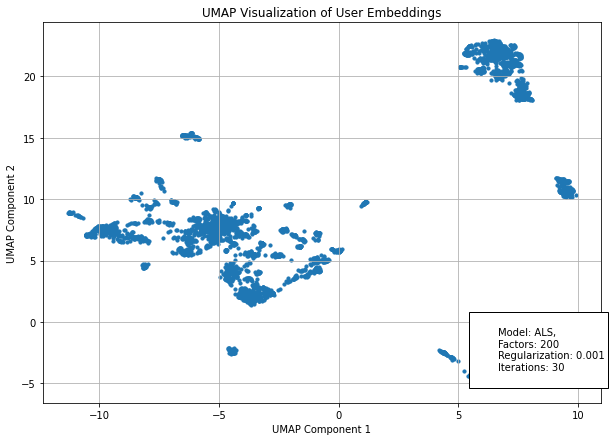

In [20]:
fals.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

## Clustering

#### KMeans

In [21]:
# kmeans_labels, kmeans_cosim_df, n_clusters = cl.print_kmeans(umap_embeddings_users, 29)
# kmeans_cosim_df

#### DBSCAN

[ True  True  True ...  True  True  True]
Estimated number of clusters: 33
Estimated number of noise points: 15
Silhouette Coefficient: 0.446


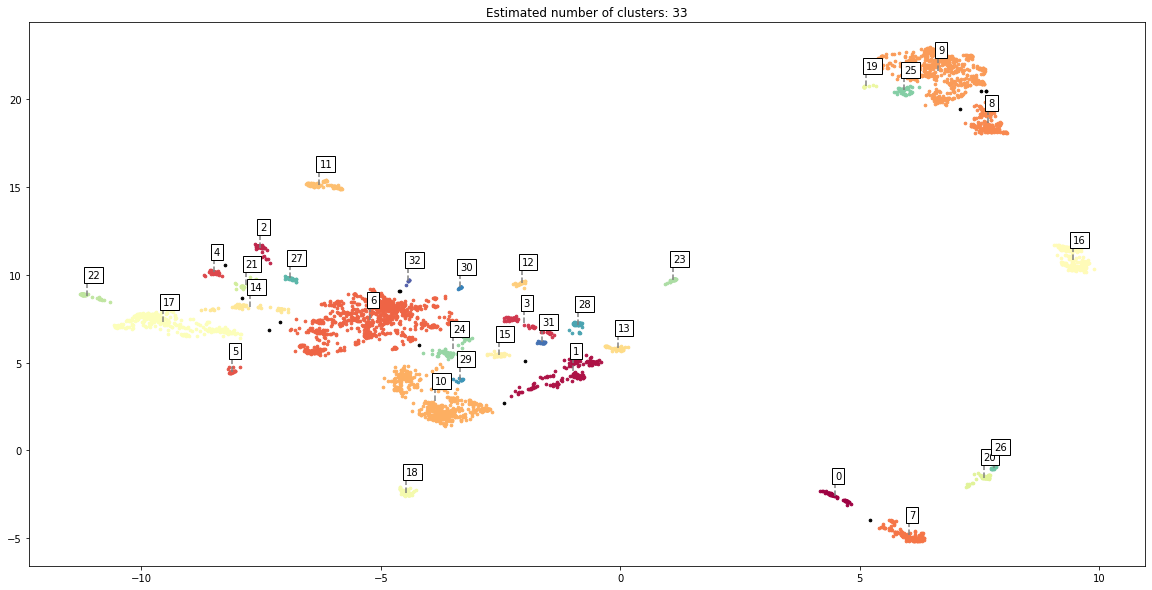

In [22]:
db_labels, db_cosim_df, n_clusters = cl.print_dbscan(umap_embeddings_users, 4)

In [23]:
db_cosim_df.head()

,Cluster #,Cosine Similarity
0,0,0.999668
1,1,0.984957
2,2,0.999962
3,3,0.999019
4,4,0.999981


In [24]:
train_df_with_clusters = cl.create_df_with_cl(umap_embeddings_users, db_labels, train_df)
# train_df_with_clusters.head(2)

In [25]:
userid = 'numeric_user_id'
itemid = 'numeric_trackable_name'
# pd.set_option('display.max_colwidth', None)

result = test_df.groupby(userid)[itemid].unique().reset_index()
result.columns=[userid, 'actual']
result.head(6)

count_trname_by_cluster = cl.create_count_trname_by_cluster_dict(n_clusters, train_df_with_clusters, result)

In [26]:
count_trname_by_cluster[12].head(10)

,numeric_trackable_name,count
0,14,2062
1,31,273
2,1252,268
3,737,262
4,443,261
5,51,184
6,838,178
7,1105,168
8,61,155
9,950,105


In [27]:
clusters = cl.create_usual_features_in_clusters(count_trname_by_cluster, threshold_by_item=0.1, threshold_by_main_group=0.5)

In [28]:
# clusters
# mapping_matrix_trackable.head(12)

In [183]:
# create clusters with sting dis
pd.set_option('display.max_colwidth', None)

def create_clusters_disease():
    clusters_dis={}
    mapping_dict = map_new.set_index('numeric_trackable_name')['trackable_name'].to_dict()
    for cluster_id, numeric_trackable_names in clusters.items():
        clusters_dis[cluster_id] = [mapping_dict.get(numeric_trackable_name, numeric_trackable_name) for numeric_trackable_name in numeric_trackable_names]

    df_clusters = pd.DataFrame(clusters_dis.items(), columns=['cluster_id', 'disease_ids'])
    df_clusters.set_index('cluster_id', inplace=True)
    return df_clusters

df_clusters = create_clusters_disease()
df_clusters

,disease_ids
cluster_id,
0,"[chronic fatigue syndrome, anxiety, depression]"
1,[ehlersdanlos syndrome]
2,[rheumatoid arthritis]
3,"[mast cell activation syndrome, postural orthostatic tachycardia syndrome pots]"
4,[lupus]
5,[ulcerative colitis]
6,"[depression, migraine, asthma, ibs, headaches, fatigue, joint pain, chronic migraines, irritable bowel syndrome, arthritis, back pain, allergies, idiopathic hypersomnia, chest pain, lower back pain, chronic daily headaches]"
7,[chronic fatigue syndrome]
8,"[fibromyalgia, anxiety]"


# Model Prediction

In [224]:
TEST_USER_ID = 323
# 30 - norm
# 1348 - одни и те же заболевания
# 999 - 1 старое не вошло

recs = model_als.recommend(userid=userid_to_id[TEST_USER_ID],  
                        user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
                        N=10, 
                        recalculate_user=True,
                        filter_already_liked_items=False)

recs

(array([  8,   7, 210,  31, 182, 825, 207, 434, 103, 725], dtype=int32),
 array([0.9892128 , 0.98825085, 0.9842735 , 0.97551525, 0.910294  ,
        0.21575992, 0.18748316, 0.17693347, 0.17561547, 0.16323526],
       dtype=float32))

In [225]:
cluster = user_df(train_df_with_clusters,TEST_USER_ID)["cluster_id"].unique()[0]
opisanie = df_clusters.loc[cluster].iloc[0] 
print("Cluster =", cluster, ":", opisanie)

Cluster = 1.0 : ['ehlersdanlos syndrome']


In [226]:
user_df_train = user_df(train_df,TEST_USER_ID)
user_df_test = user_df(test_df,TEST_USER_ID)

def sort_df_by_sum_value(df):
    df[['numeric_trackable_name','trackable_value']]
    df = df.groupby('numeric_trackable_name')['trackable_value'].sum().reset_index()
    df = df.sort_values(by='trackable_value', ascending=False)
    return df

value_user_train = sort_df_by_sum_value(user_df_train)
value_user_test = sort_df_by_sum_value(user_df_test)

diff_train_test_data = pd.merge(value_user_train,value_user_test, how='outer', on='numeric_trackable_name')
diff_train_test_data = diff_train_test_data.rename(columns={'trackable_value_x': 'weight_all','trackable_value_y':'weight_last'})
diff_train_test_data = pd.merge(diff_train_test_data,mapping_matrix_trackable, how='left', on='numeric_trackable_name')
diff_train_test_data = diff_train_test_data.iloc[:, [0,3,1,2]]

diff_train_test_data

,numeric_trackable_name,trackable_name,weight_all,weight_last
0,243,postural orthostatic tachycardia syndrome,23,1
1,8,ehlersdanlos syndrome,22,2
2,9,depression,20,3
3,209,chiari malformation,17,3
4,32,anxiety,9,1


In [227]:
# map_new['index'] - верная матрица теперь для рекомендаций
# mapping_matrix_trackable["numeric_trackable_name"] - верная матрица для старых значений

In [228]:
recomendations = pd.DataFrame({'index': recs[0]})
recomendations = recomendations.merge(map_new, on='index', how='left')
recomendations = recomendations.drop(columns='index')

recomendations

,numeric_trackable_name,trackable_name
0,9,depression
1,8,ehlersdanlos syndrome
2,243,postural orthostatic tachycardia syndrome
3,32,anxiety
4,209,chiari malformation
5,1183,nocturia
6,239,pseudotumor cerebri
7,531,agoraphobia
8,112,juvenile rheumatoid arthritis
9,996,chronic lyme disease


In [222]:
recomendations_filtered_999999 = recomendations[recomendations["numeric_trackable_name"] != 999999]
# recomendations_filtered_999999

### recall@10

### map@10